In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.misc
import scipy.ndimage
from IPython.display import clear_output
import pandas as pd
import ast
import PIL
from PIL import Image
from torchvision import models
import time
import glob
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize
from HiPe import hierarchical_perturbation
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.rise import rise

In /anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.jpeg_

In [2]:

train_net = True
batch_size = 4

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

classes = range(10)

PATH = './mnist_net.pth'

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)


/anaconda/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class Net(nn.Module):
    # https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output
    

def run_epochs(net, dataloader, criterion, optimizer, num_epochs, threshold):
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                avg_loss = running_loss / 2000
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, avg_loss))
                if avg_loss <= threshold:
                    return net
                running_loss = 0.0

    print('Finished Training')
    return net


net = Net()
num_epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

threshold = 0.05
    
if train_net:
    
    net = run_epochs(net, trainloader, criterion, optimizer, num_epochs, threshold)

    torch.save(net.state_dict(), PATH)
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    net.eval()

    for data in testloader:
        test_images, test_labels = data
        outputs = net(test_images)
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

        c = (predicted == test_labels).squeeze()
        label = test_labels.item()
        class_correct[label] += c.item()
        class_total[label] += 1

    print('Accuracy of the network on test set: %d %%' % (
        100 * correct / total))

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    
else: 
    net = Net()
    net.load_state_dict(torch.load(PATH))

    net.eval()
    


/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 0.531
[1,  4000] loss: 0.163
[1,  6000] loss: 0.106
[1,  8000] loss: 0.101
[1, 10000] loss: 0.089
[1, 12000] loss: 0.091
[1, 14000] loss: 0.079
[2,  2000] loss: 0.071
[2,  4000] loss: 0.063
[2,  6000] loss: 0.049
Accuracy of the network on test set: 98 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 97 %
Accuracy of     7 : 96 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %


In [9]:

def get_im(img):
    npimg = img.numpy()
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    return npimg

def run_hipe(ti, tl, dataiter, hipeparams):

    outputs = torch.softmax(net(ti), dim=1)[0]
    predicted = classes[torch.argmax(outputs).item()]
    actual = classes[tl]

    fig, axs = plt.subplots(1, len(classes), figsize=(30,10))
    cols = []
    img = get_im(ti[0])

    for target in classes:
        smap, b_occs = hierarchical_perturbation(net, ti, target, **hipeparams)
        axs[target].imshow(img.reshape(28,28), cmap='gray')
        axs[target].axis('off')
        axs[target].imshow(smap[0][0], alpha=0.9, cmap='gray')
        cols.append('Class {}, {}%'.format(target, int(outputs[target]*100)))

    for ax, c in zip(axs, cols):
        ax.set_title(c)

    plt.show()
    
    
dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=False, num_workers=2))


{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


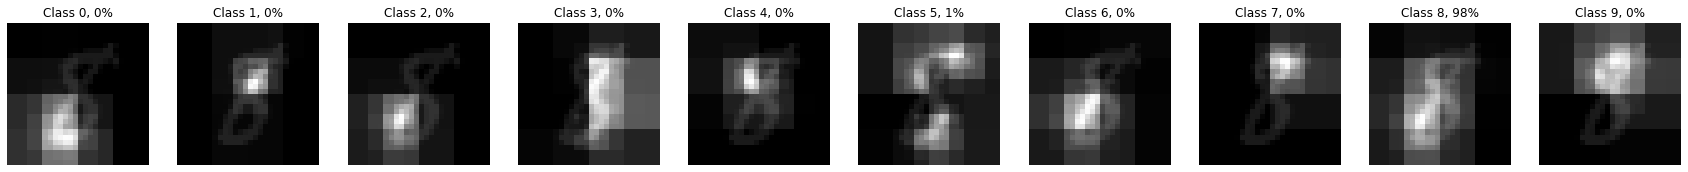

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


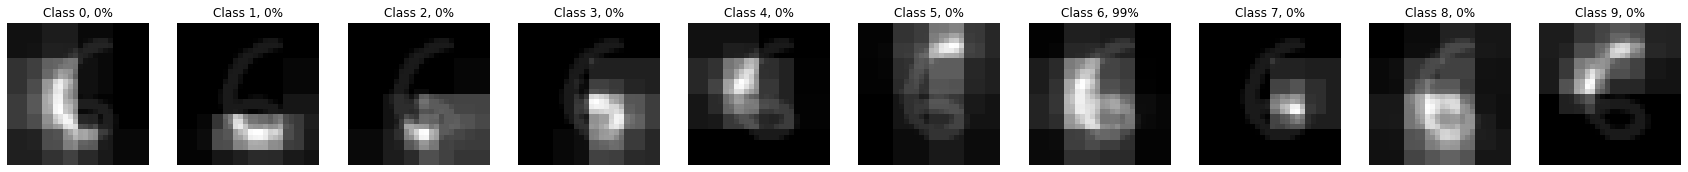

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


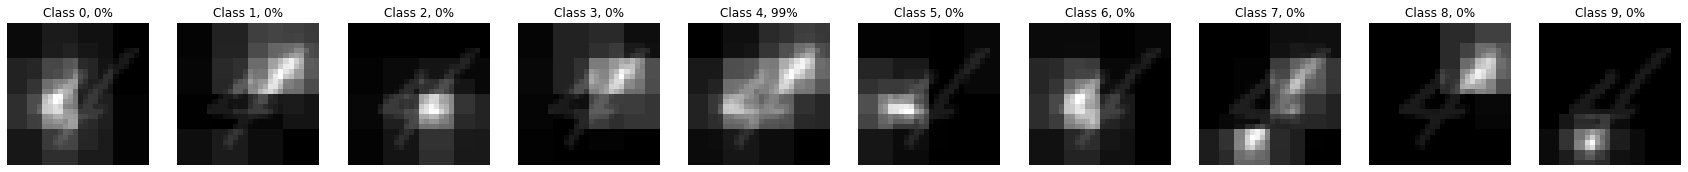

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


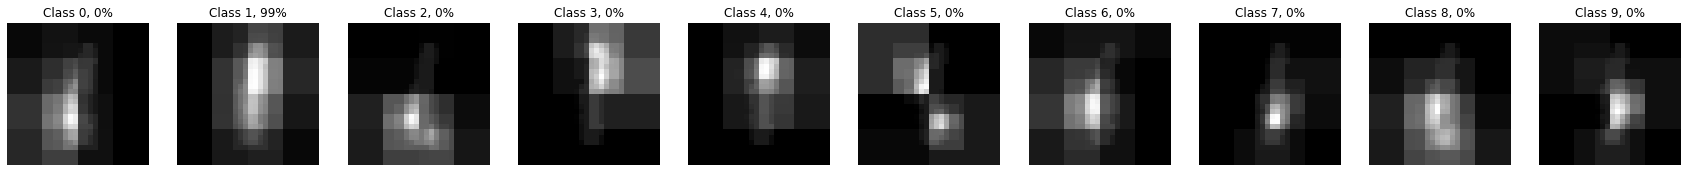

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


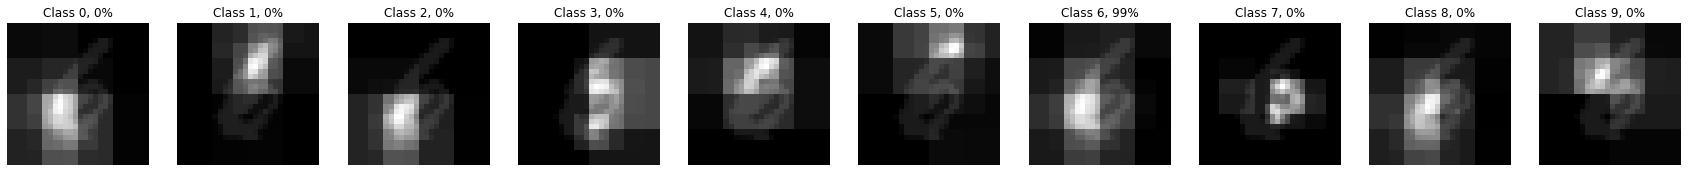

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


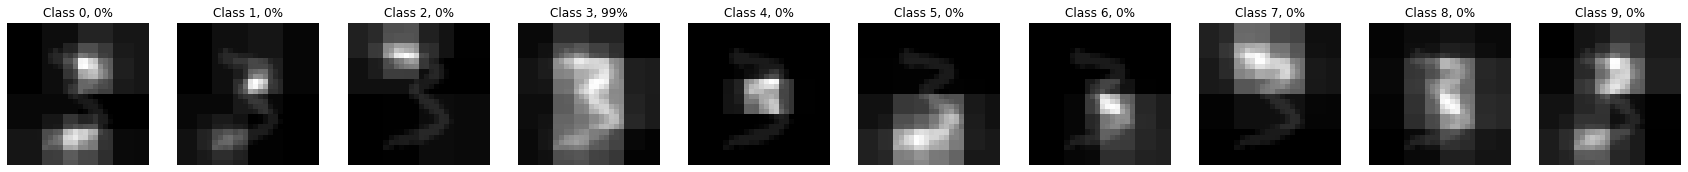

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


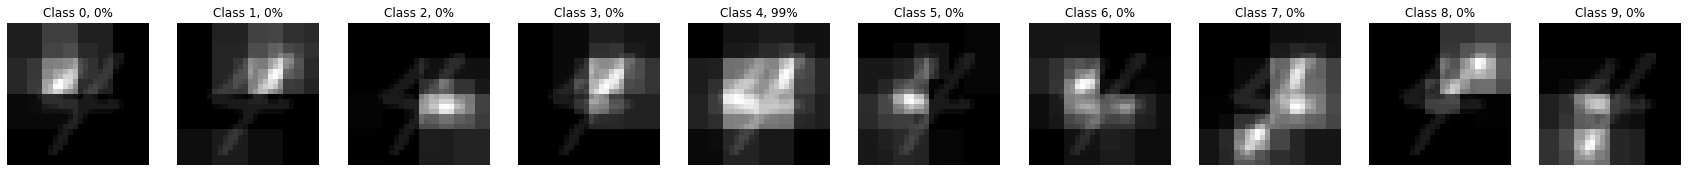

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


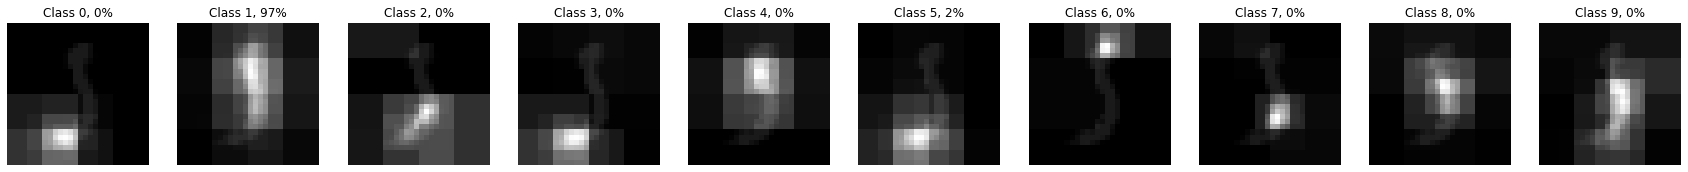

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


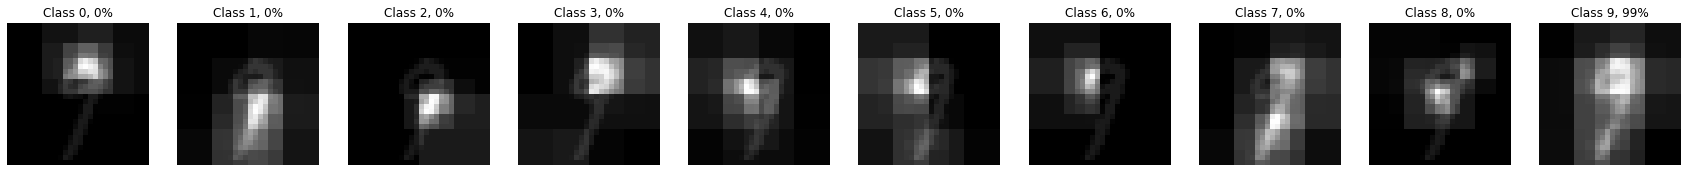

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


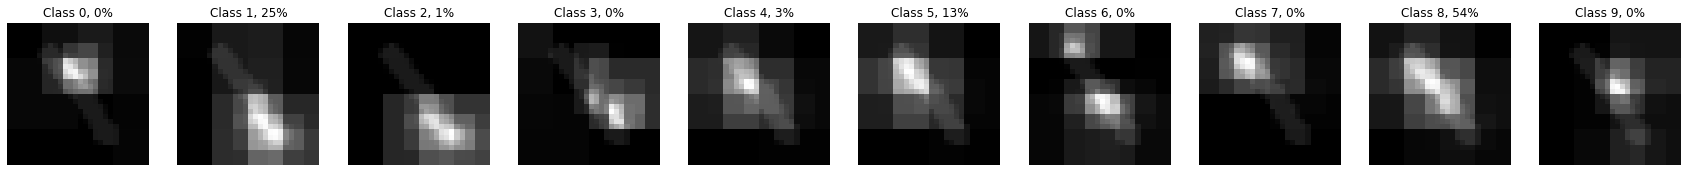

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


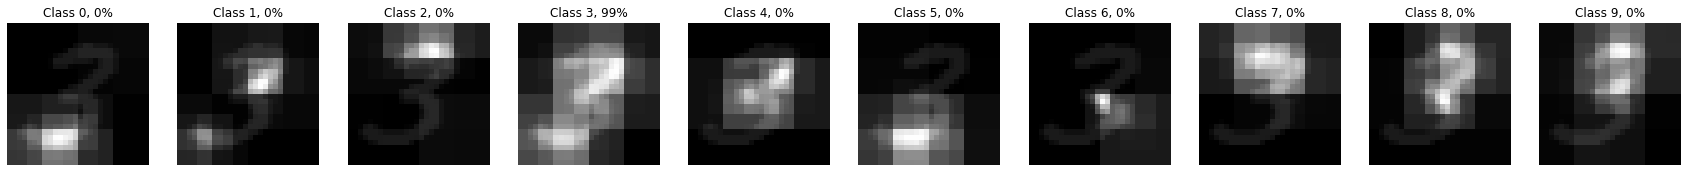

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


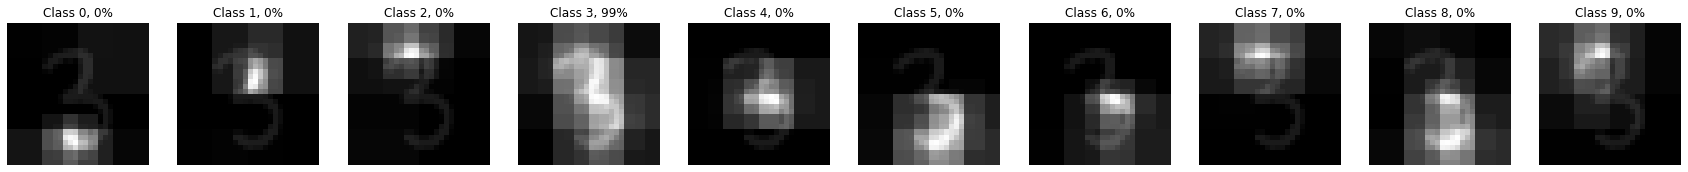

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


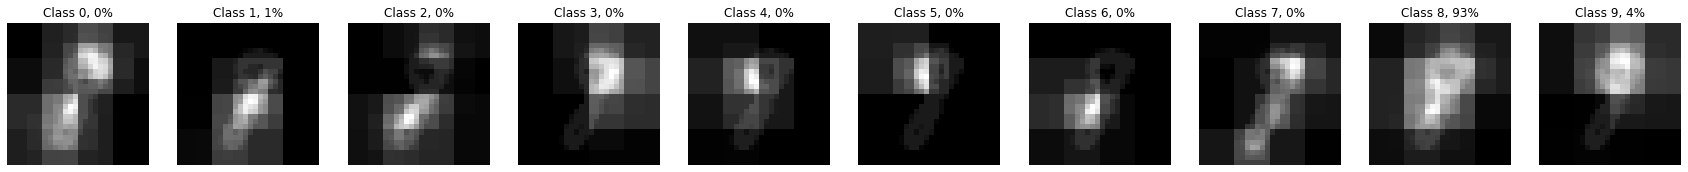

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


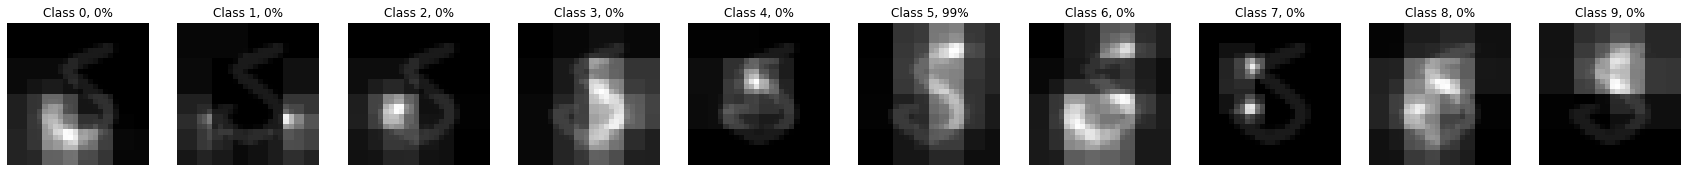

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


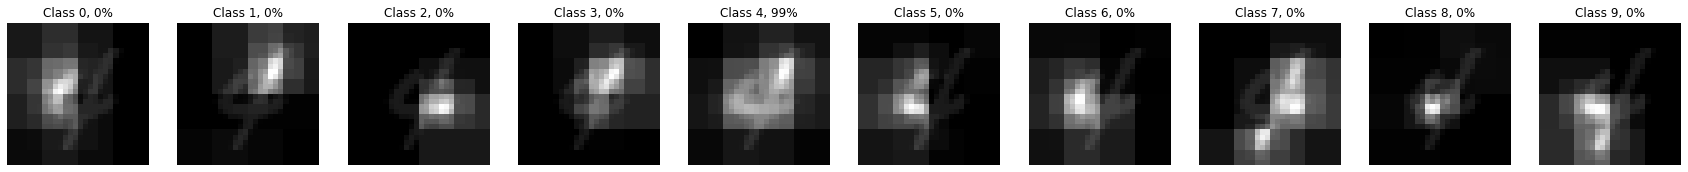

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


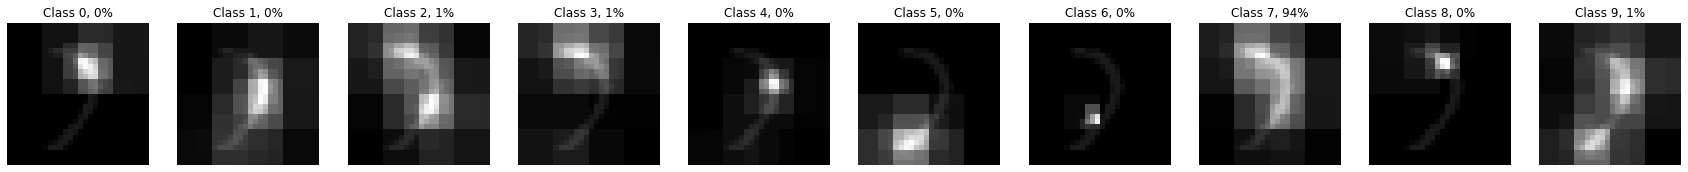

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


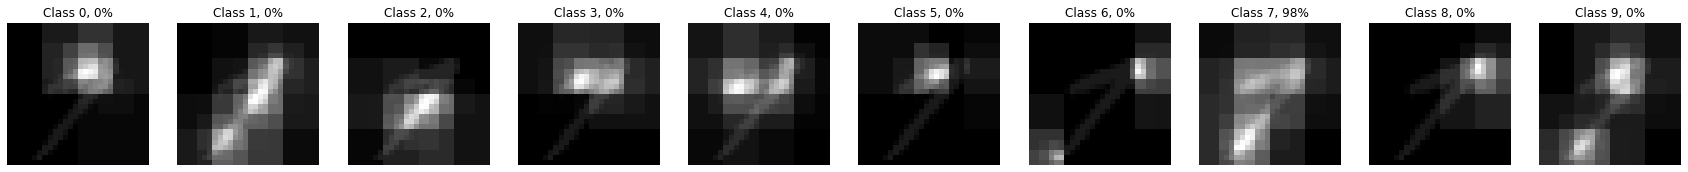

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


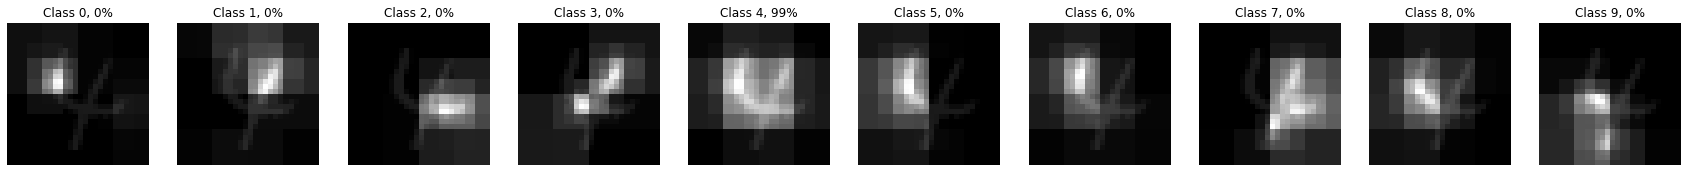

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


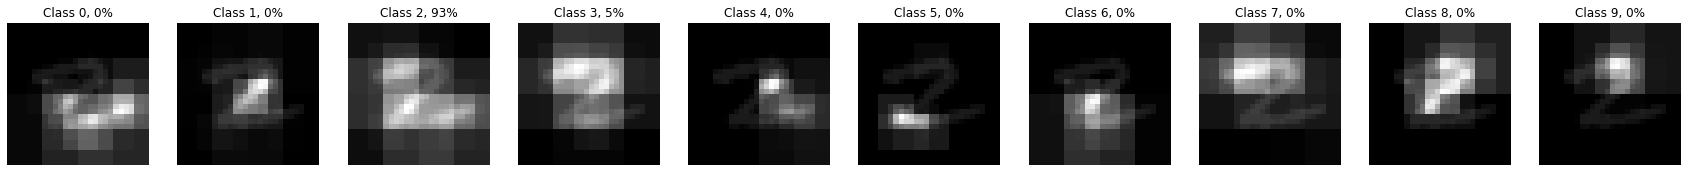

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


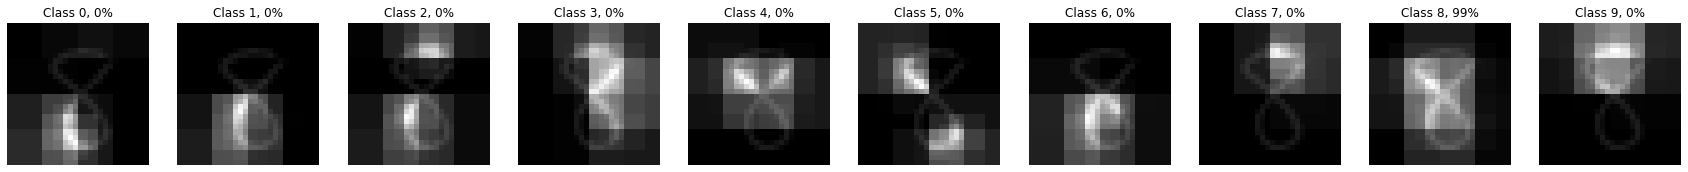

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


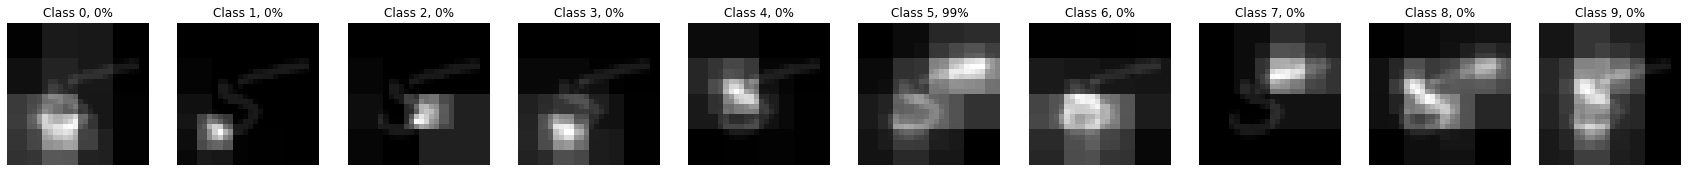

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


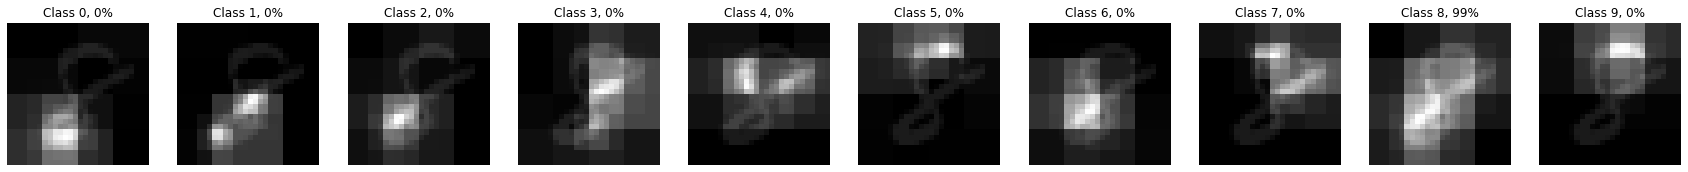

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


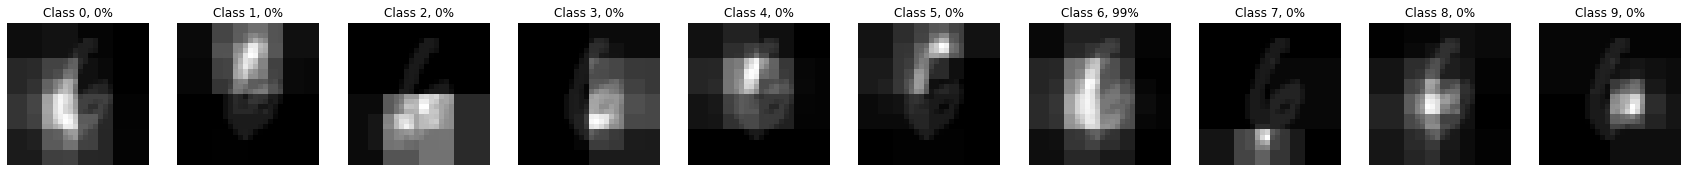

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


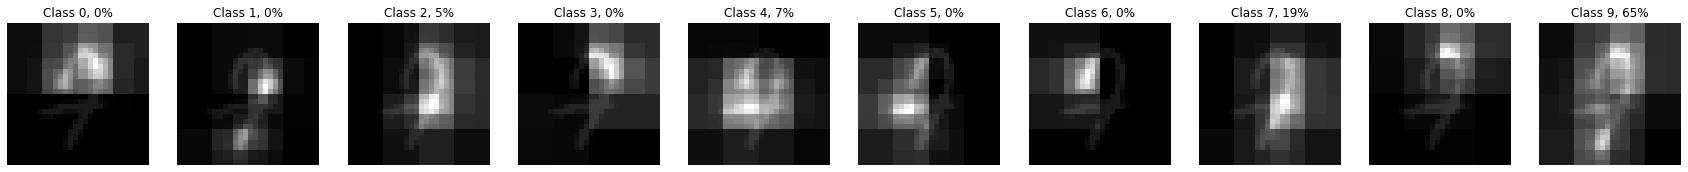

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


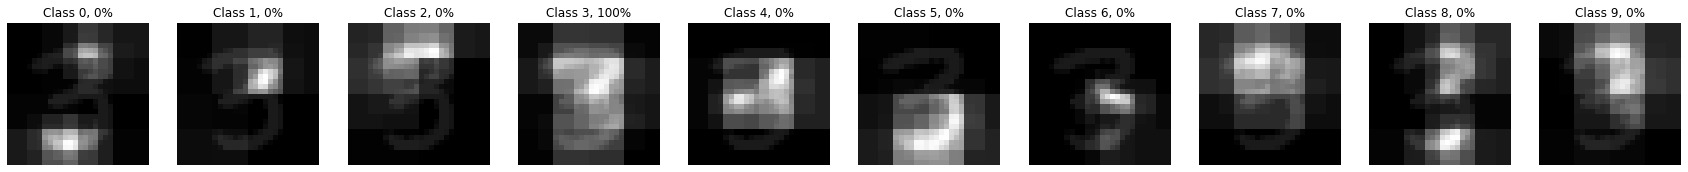

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


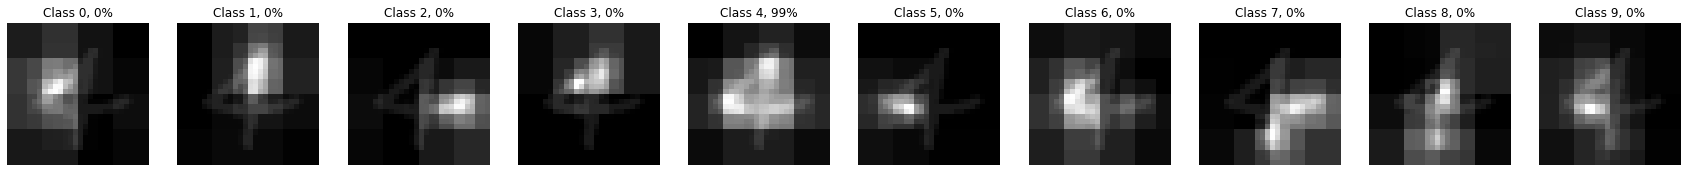

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


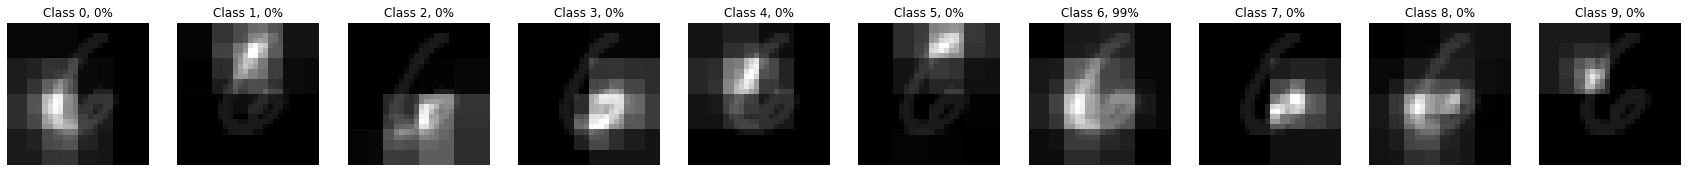

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


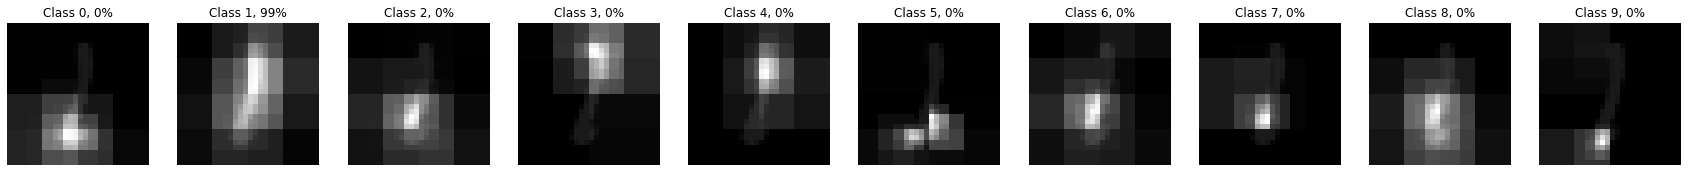

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


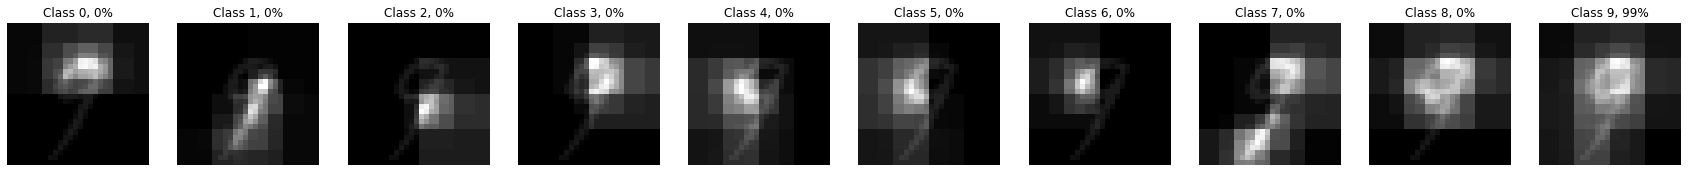

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


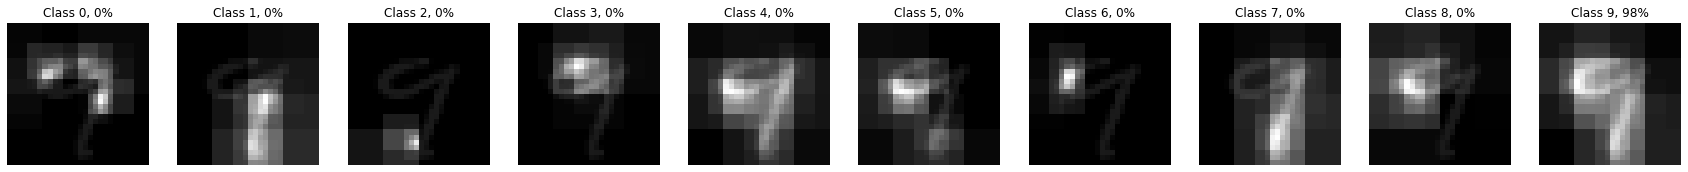

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


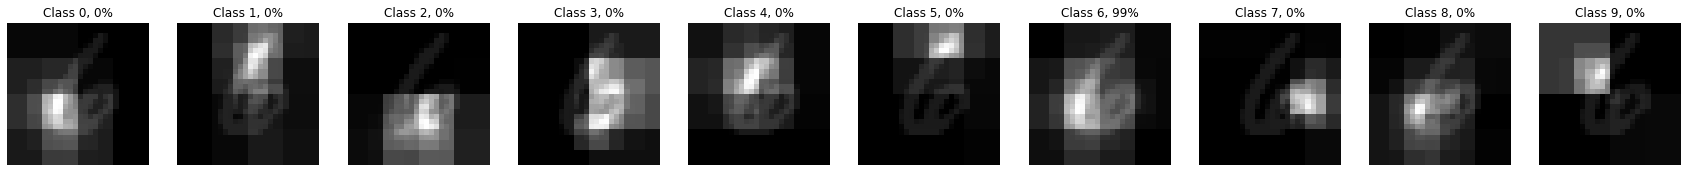

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


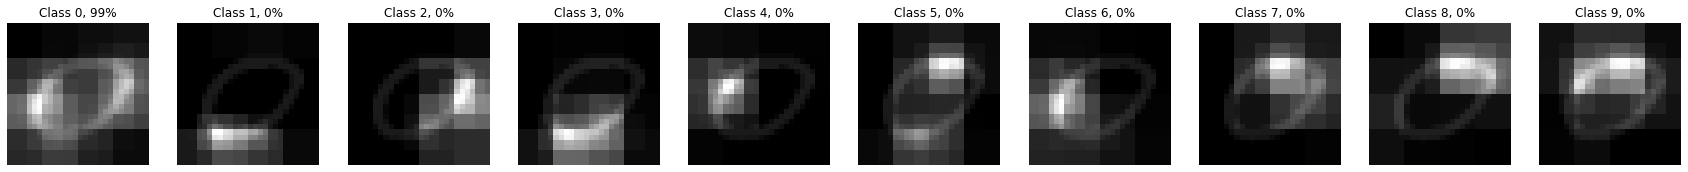

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


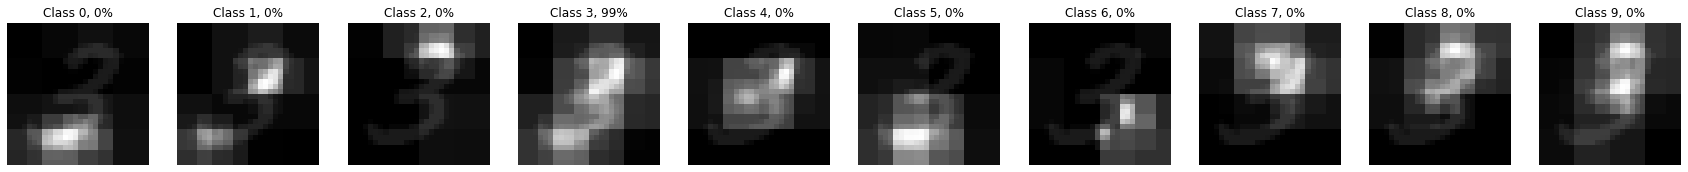

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


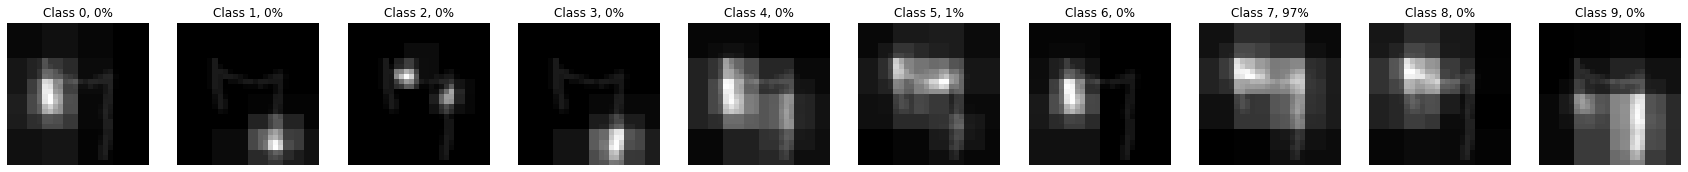

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


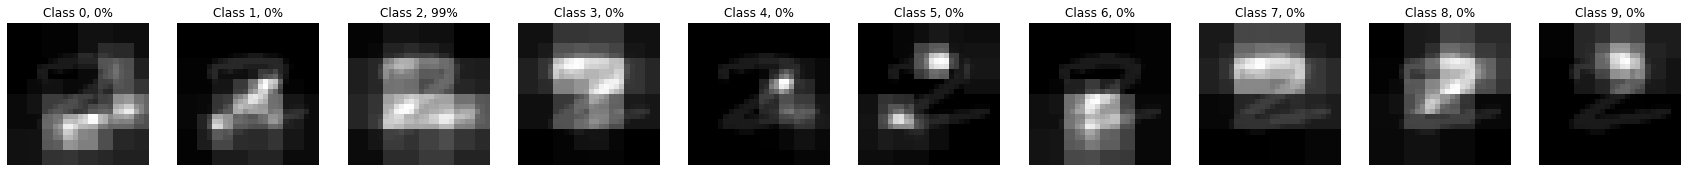

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


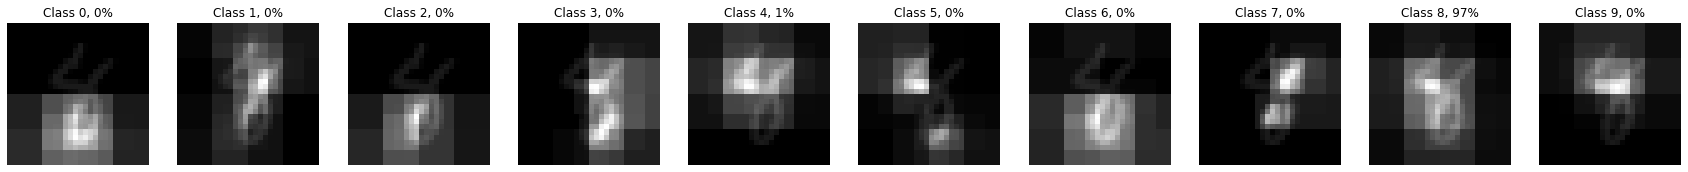

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


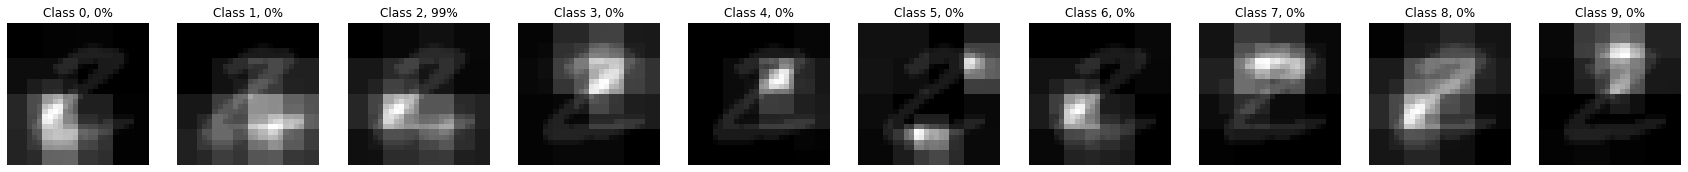

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


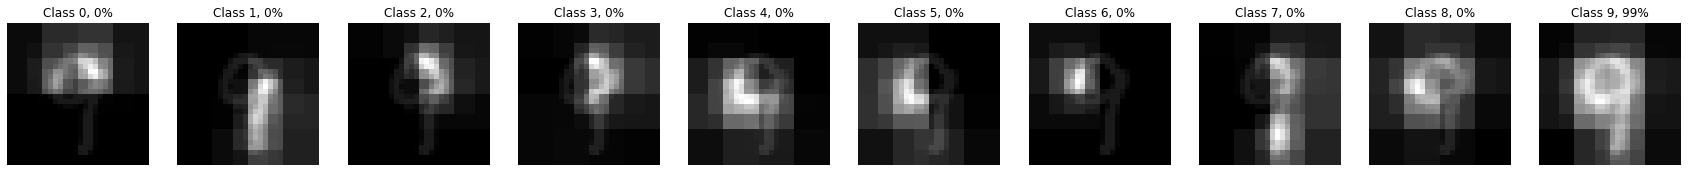

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


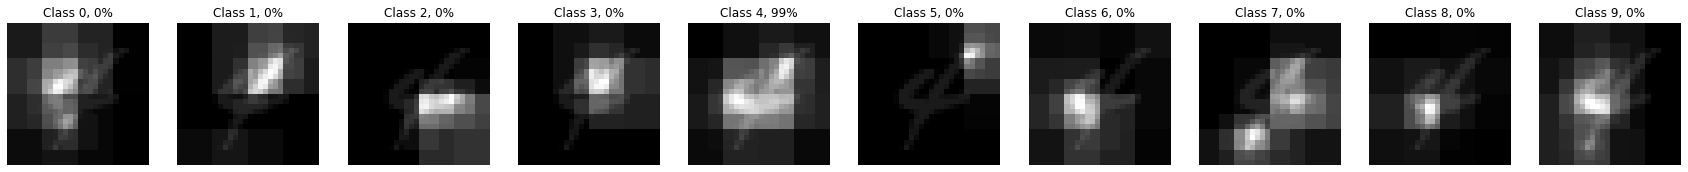

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


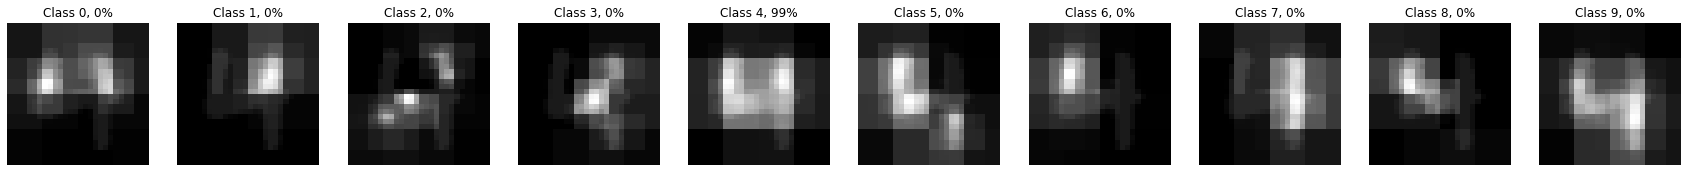

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


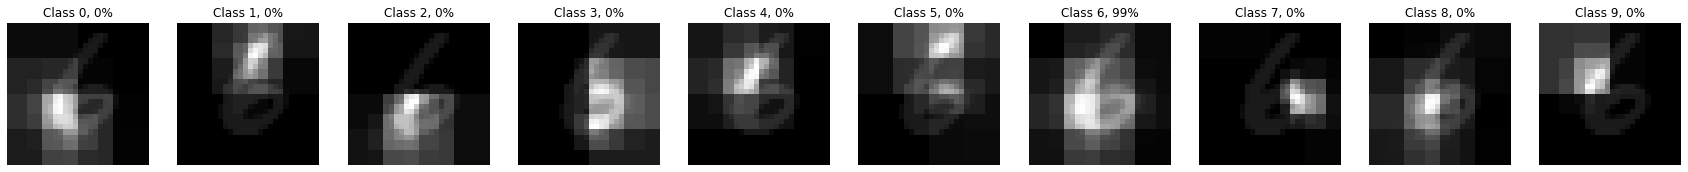

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


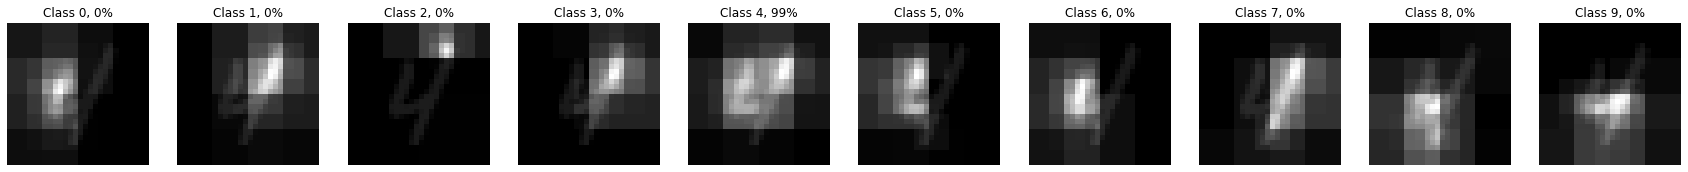

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


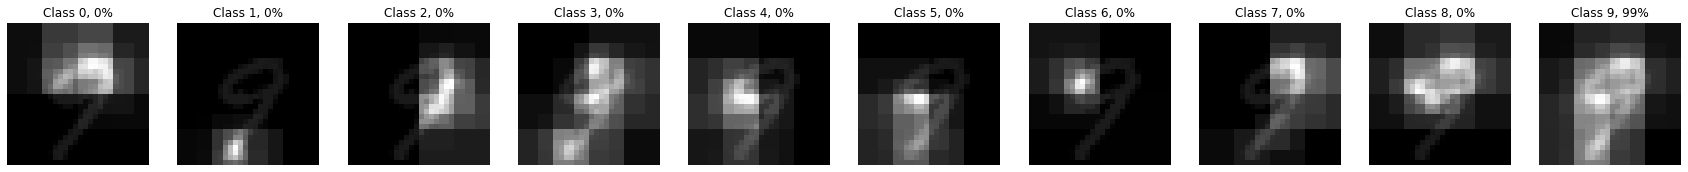

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


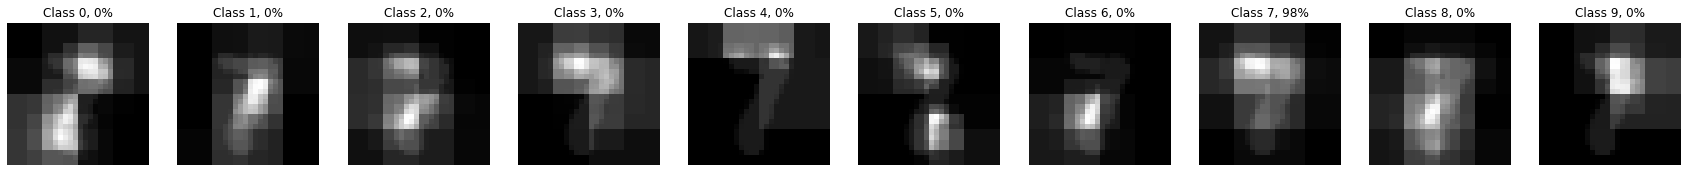

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


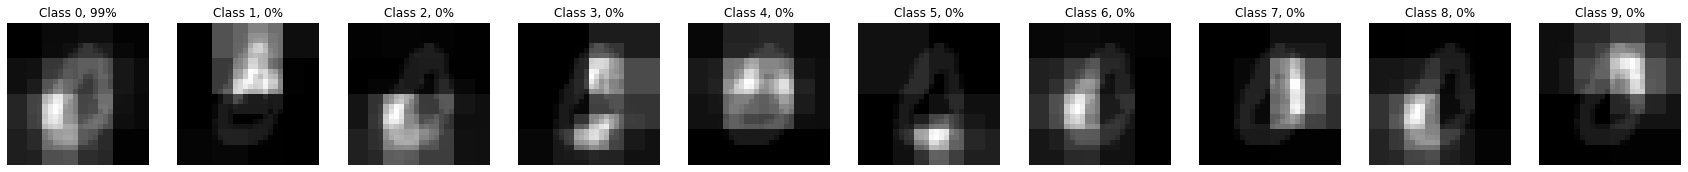

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


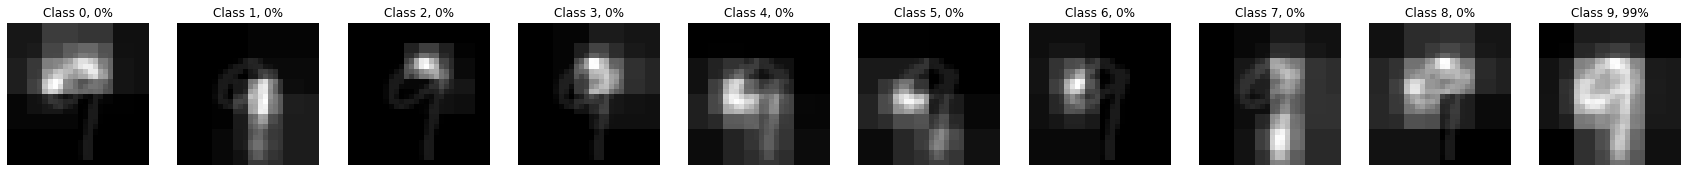

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


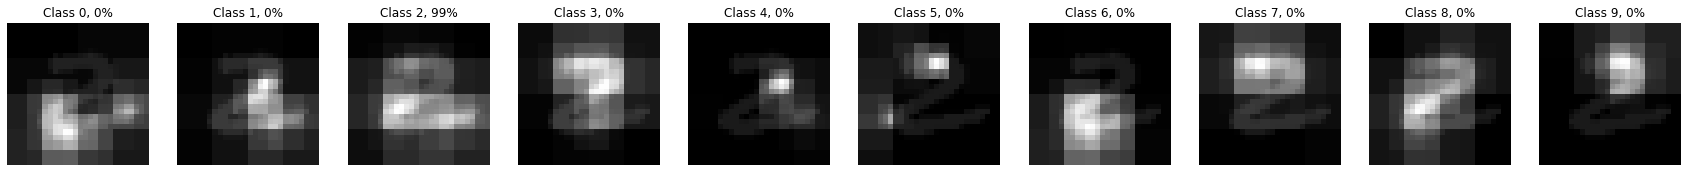

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


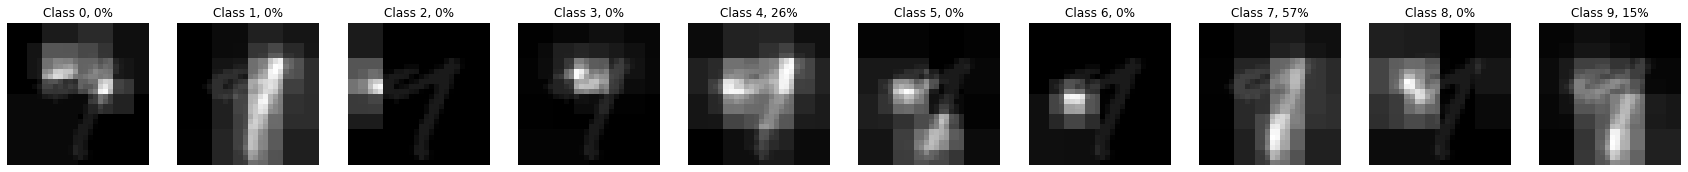

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


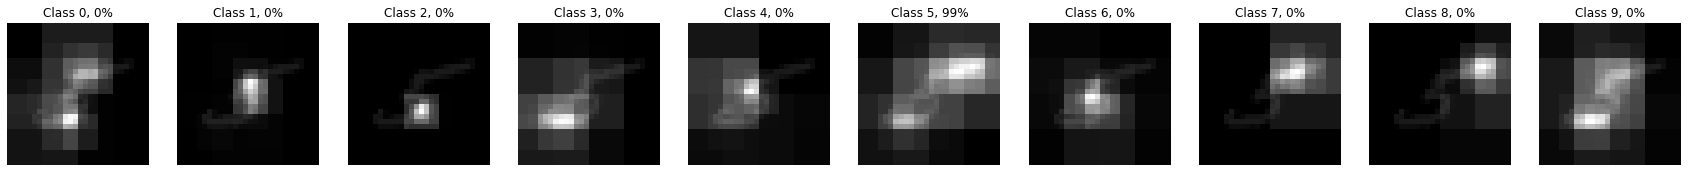

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


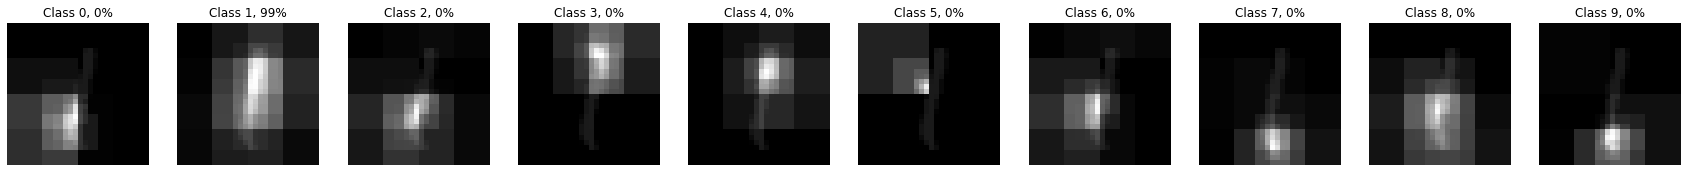

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


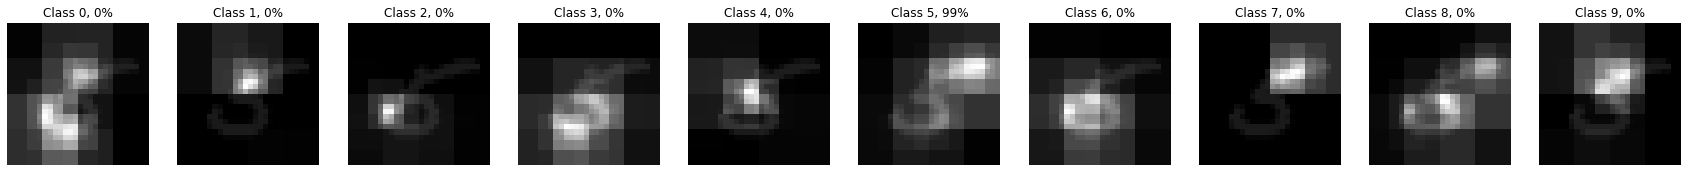

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


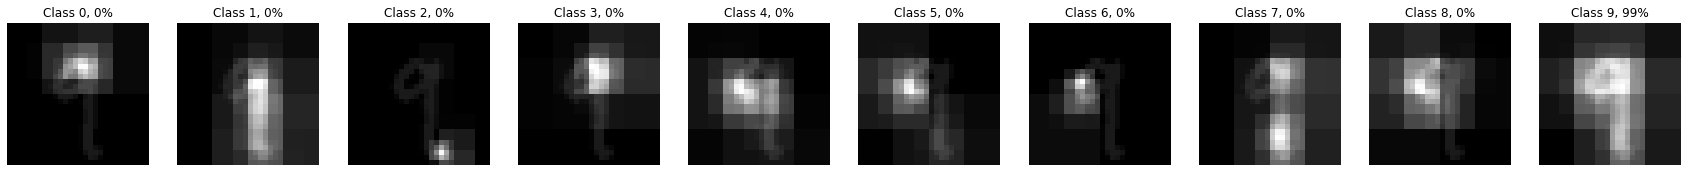

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


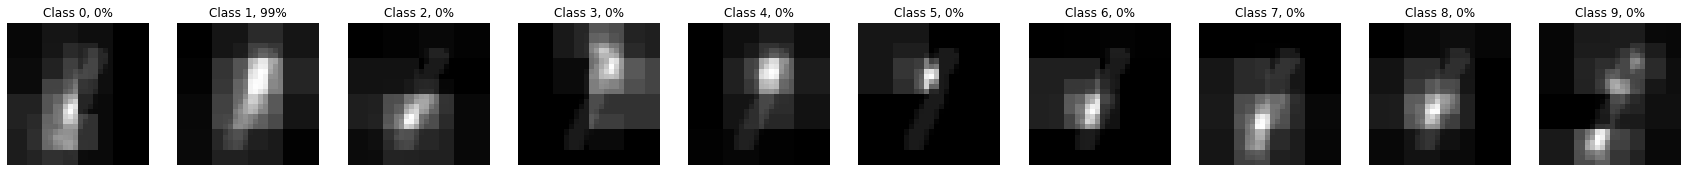

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


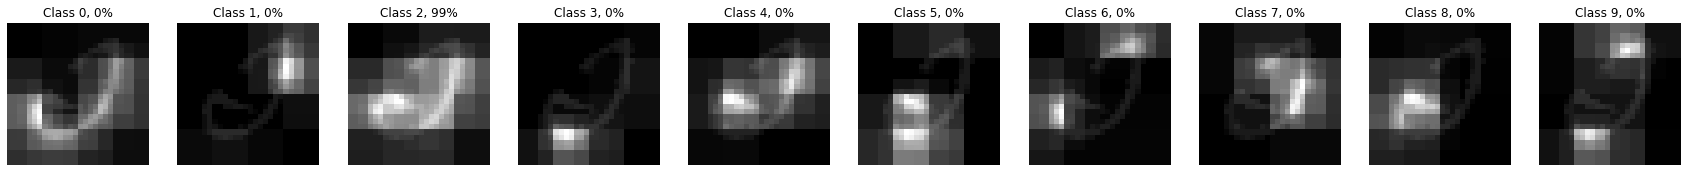

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


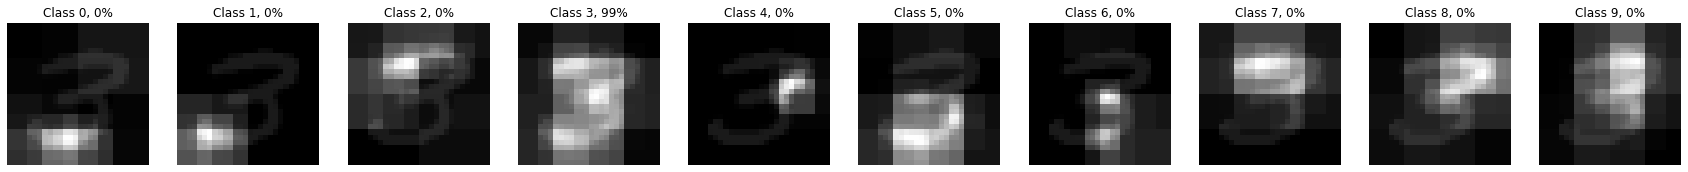

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


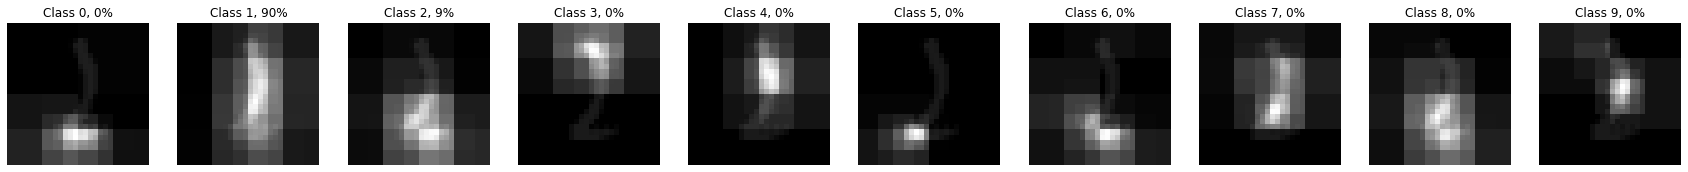

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


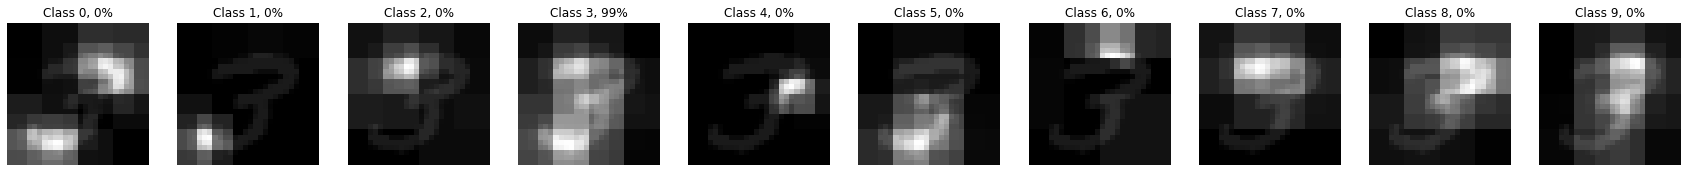

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


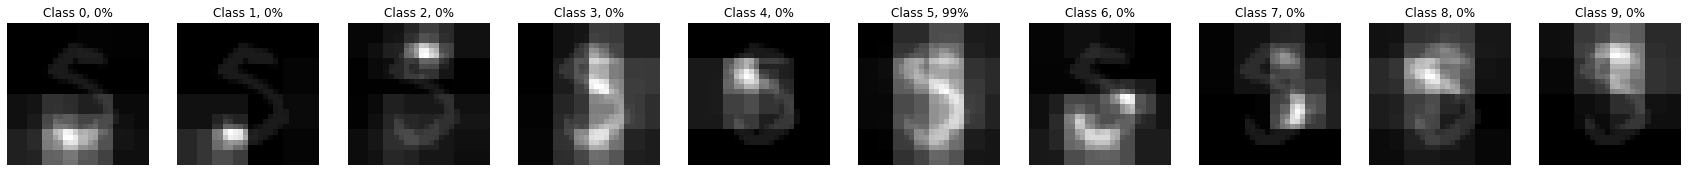

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


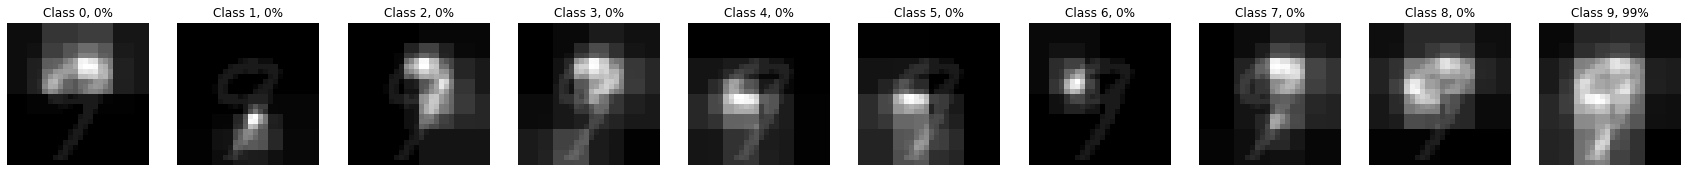

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


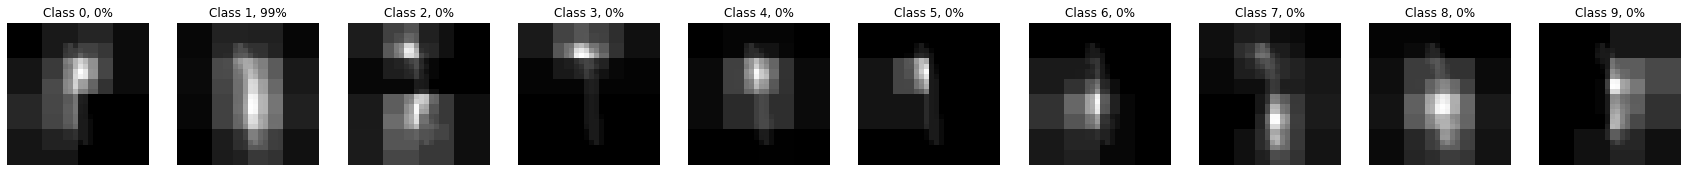

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


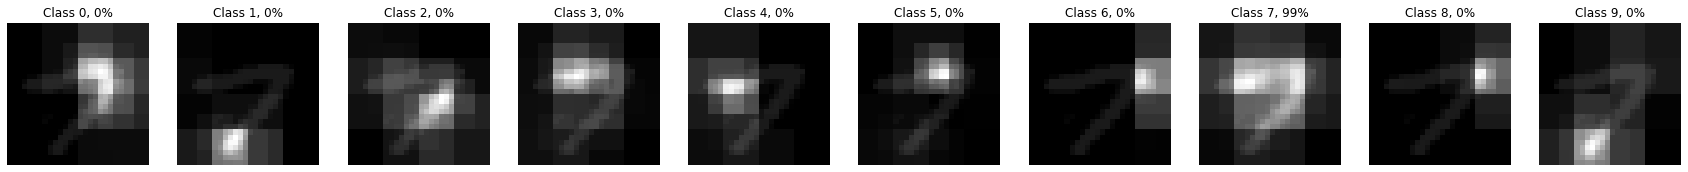

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


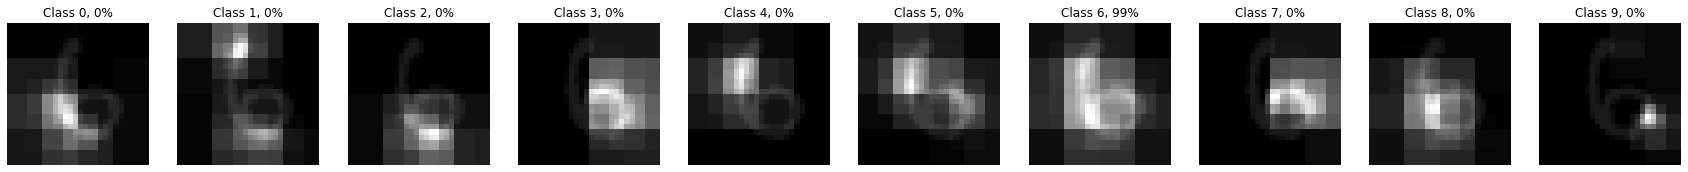

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


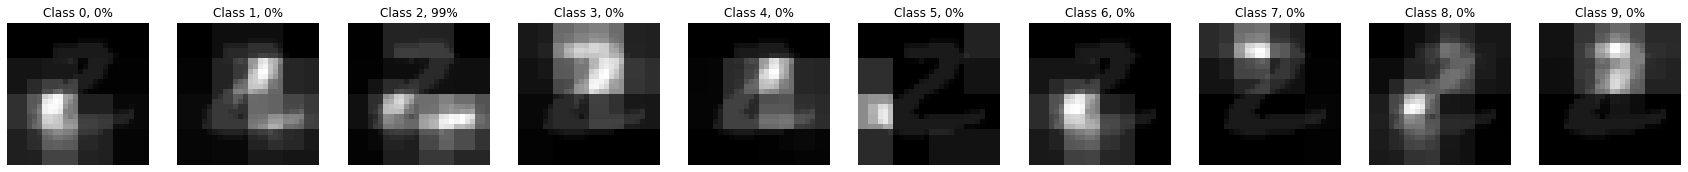

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


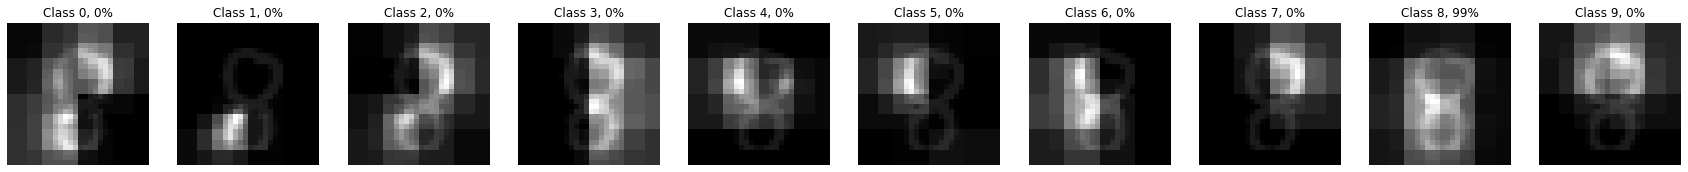

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


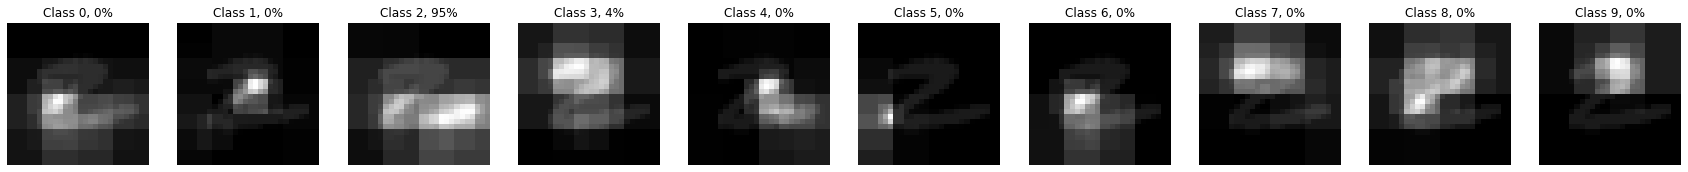

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


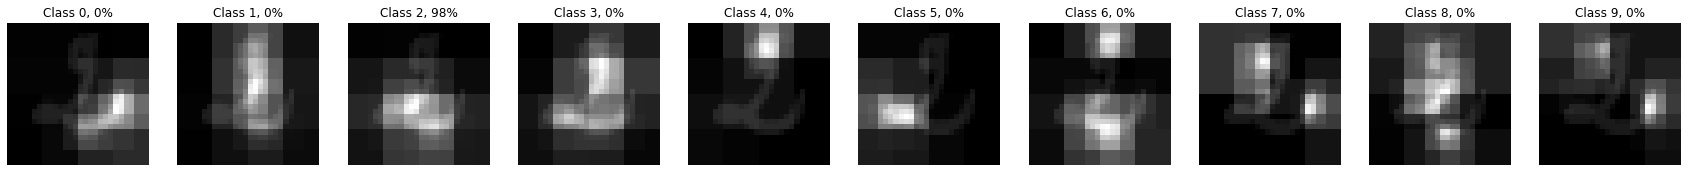

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


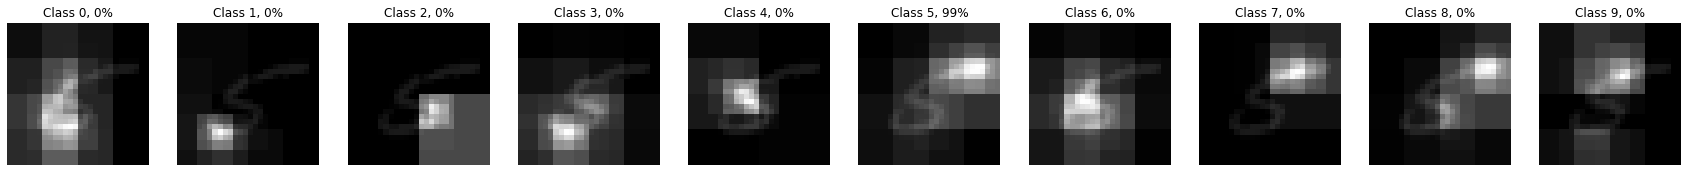

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


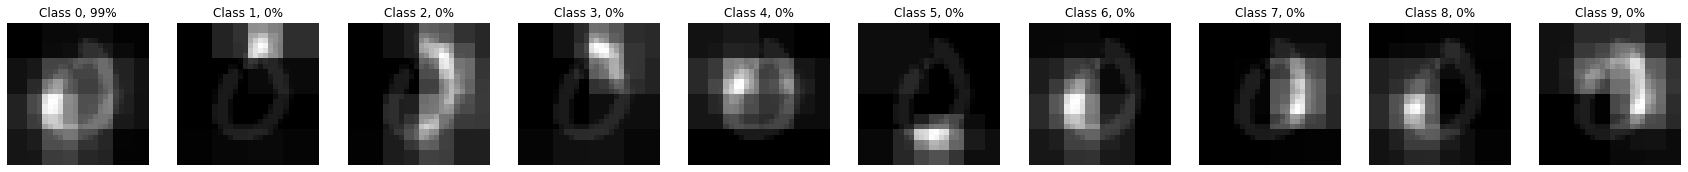

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


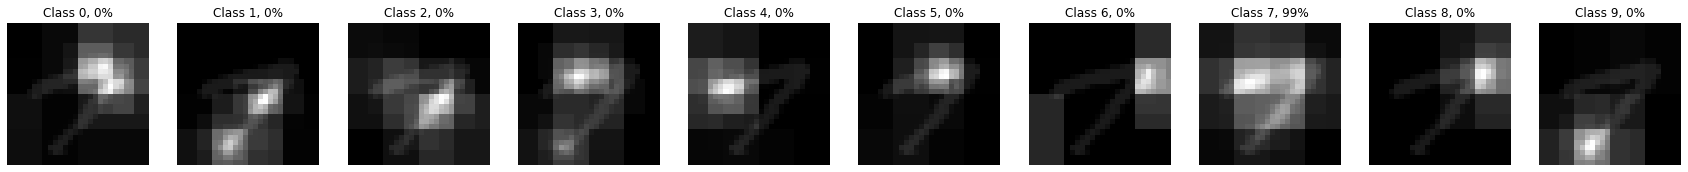

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


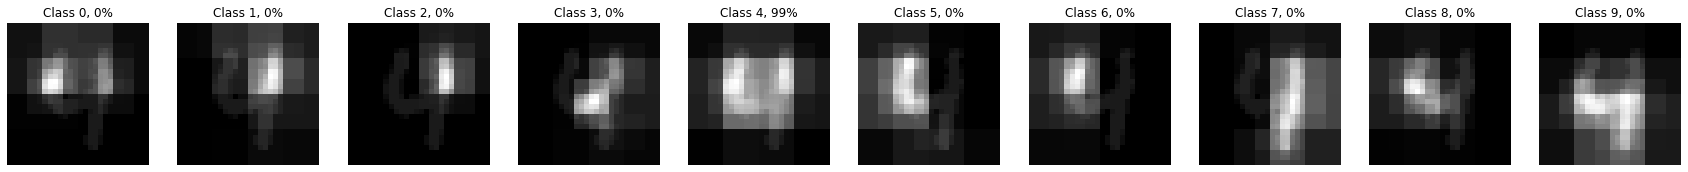

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


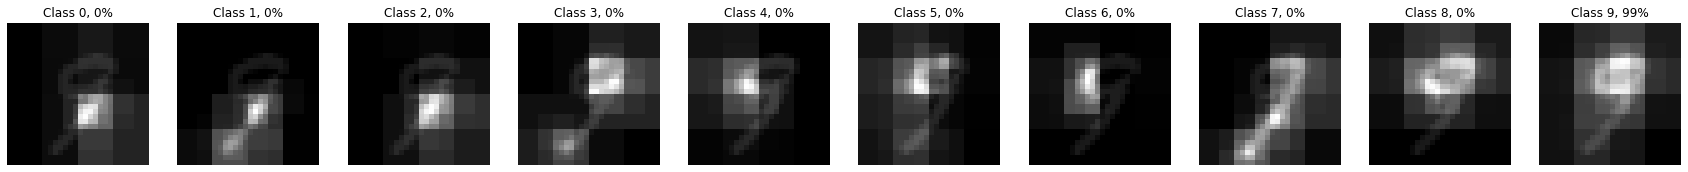

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


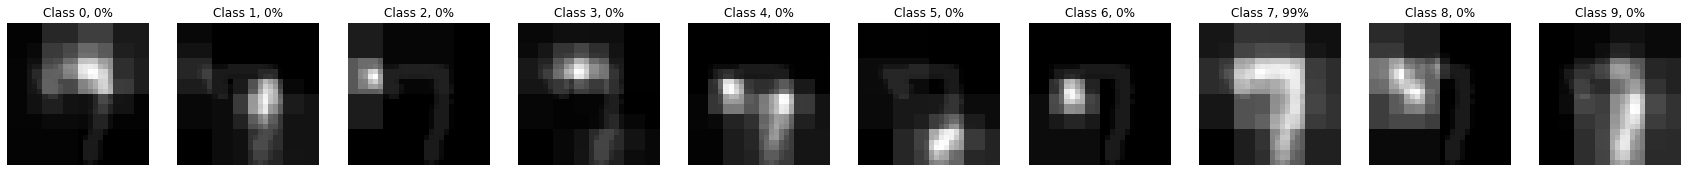

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


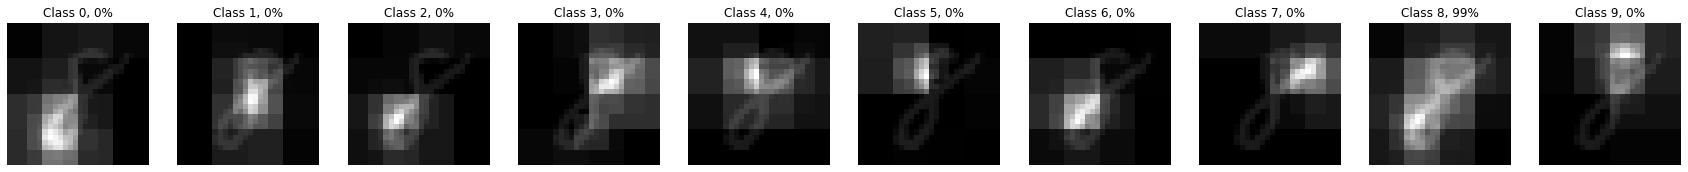

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


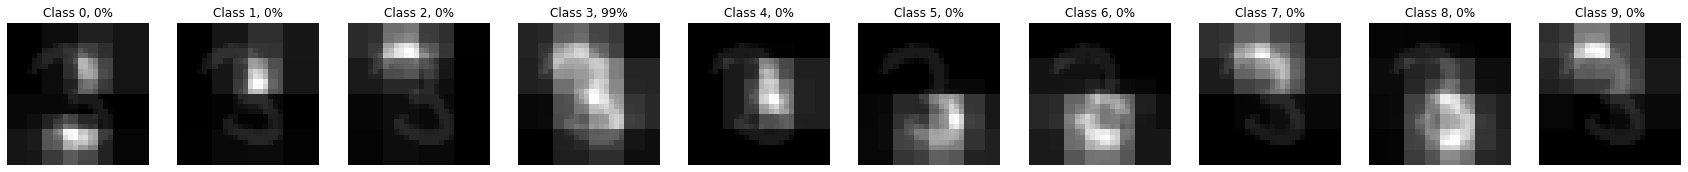

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


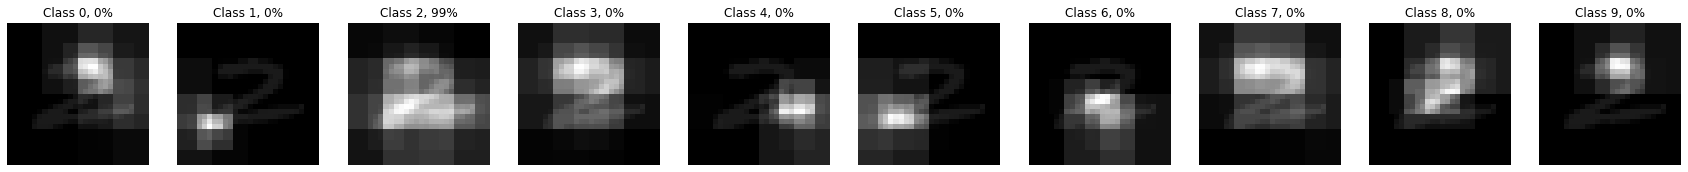

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


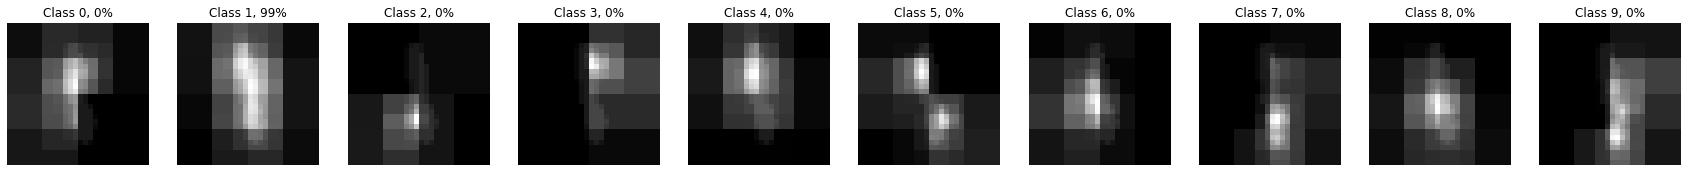

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


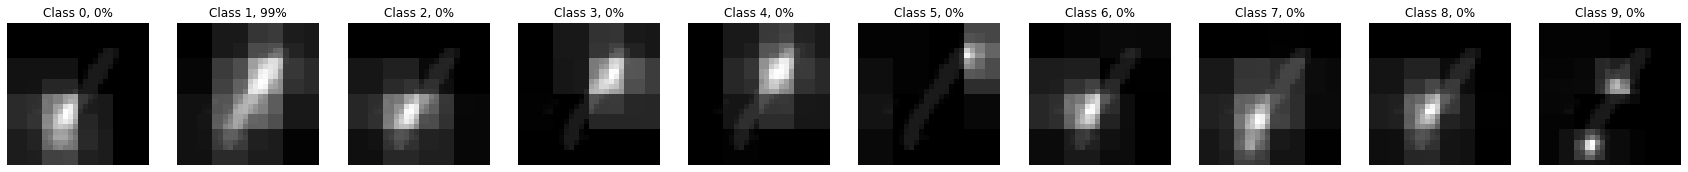

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


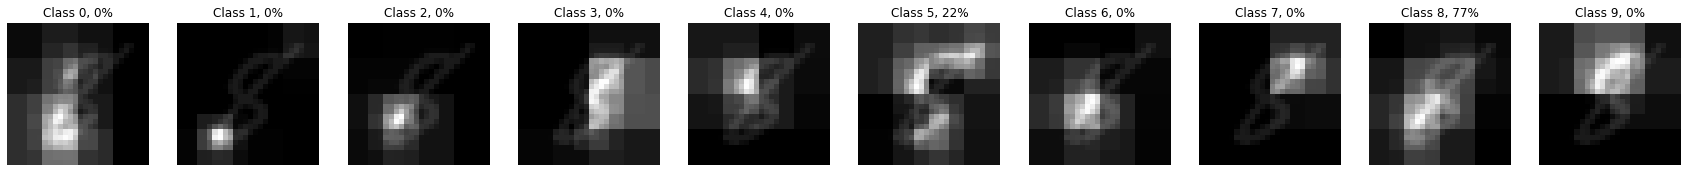

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


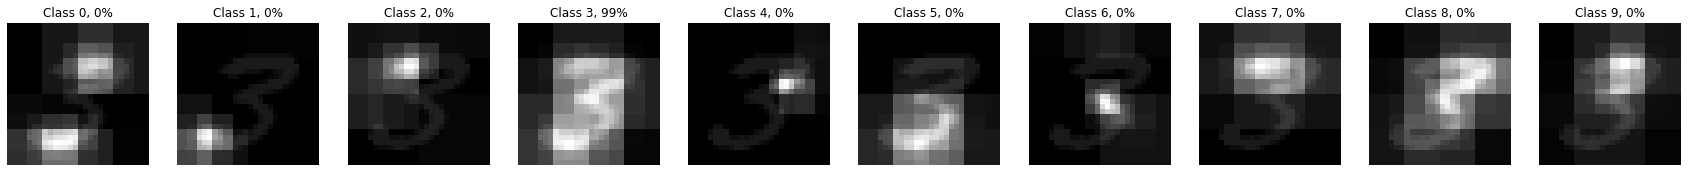

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


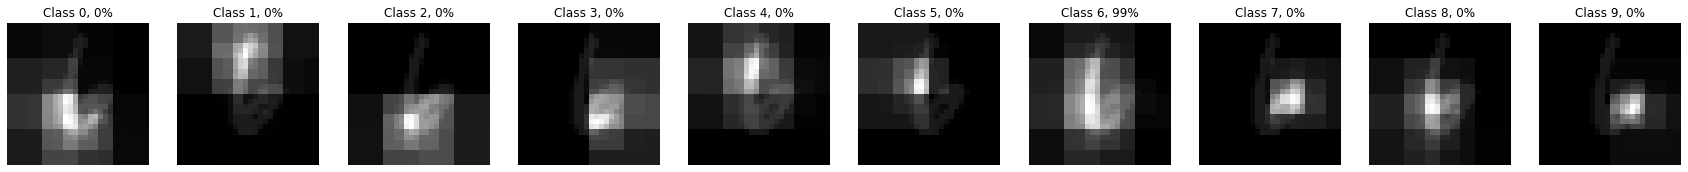

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


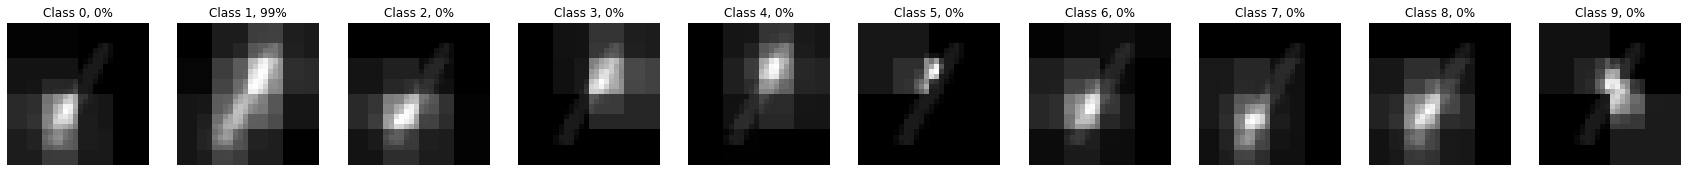

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


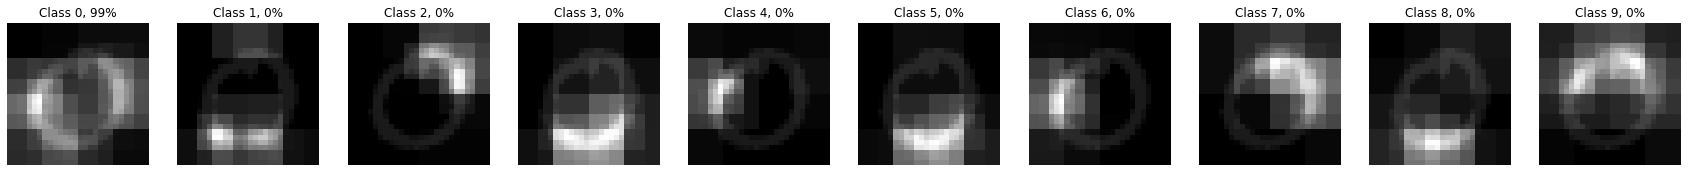

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


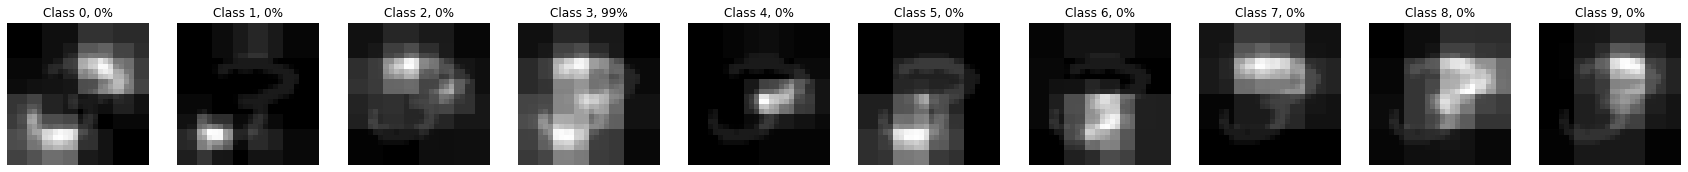

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


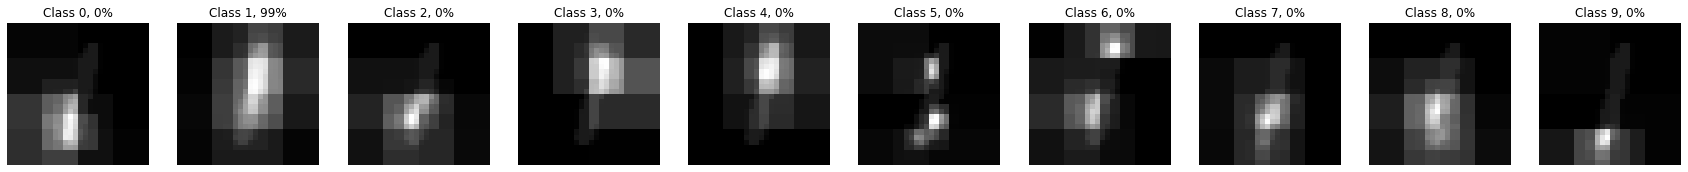

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


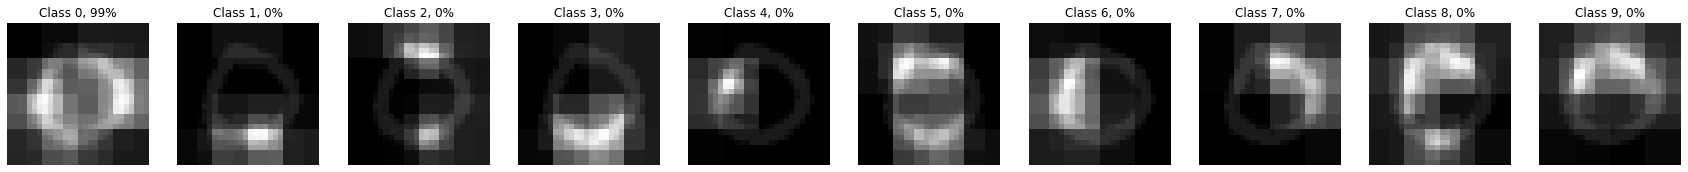

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


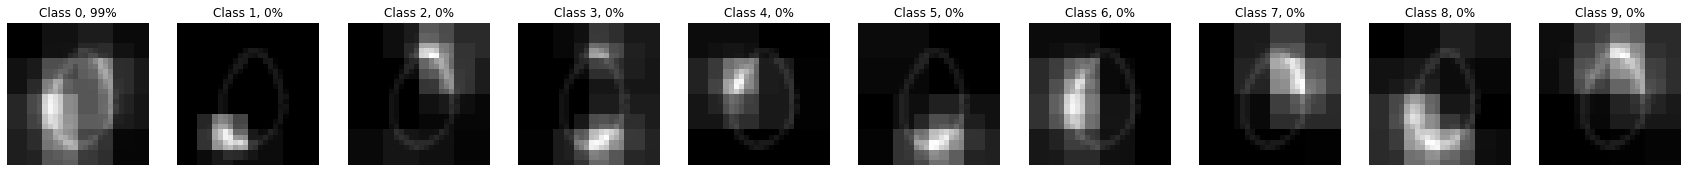

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


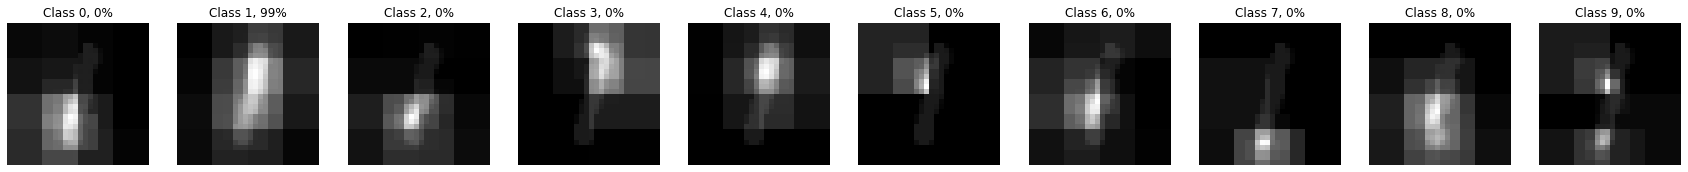

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


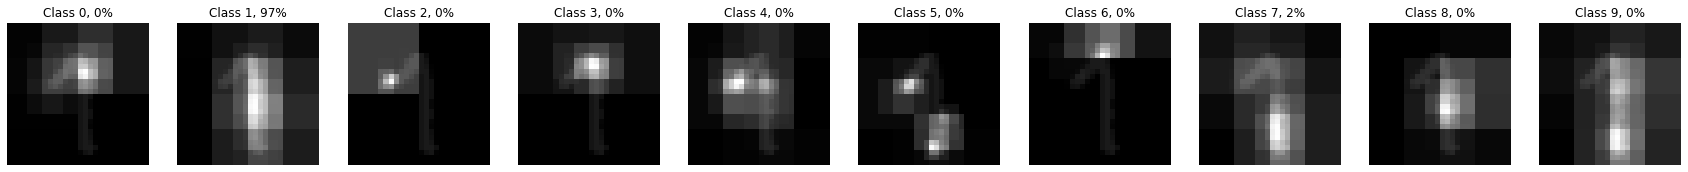

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


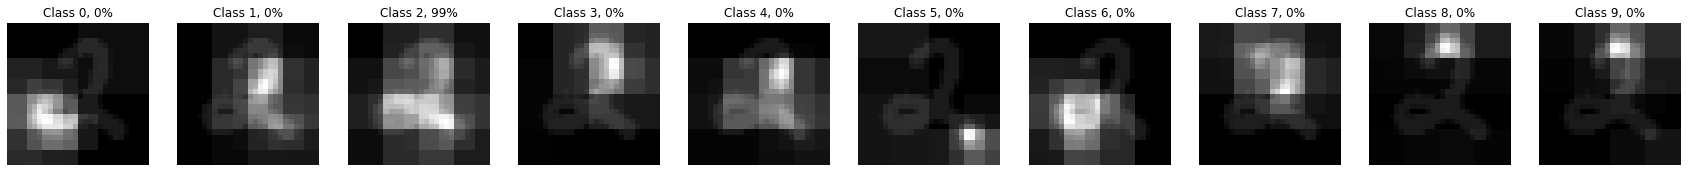

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


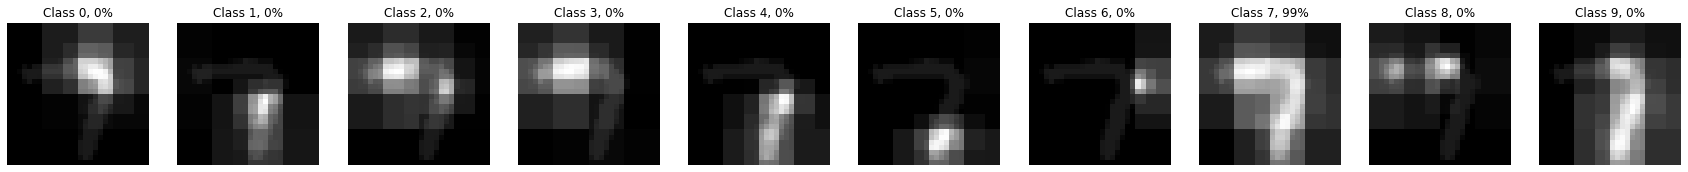

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


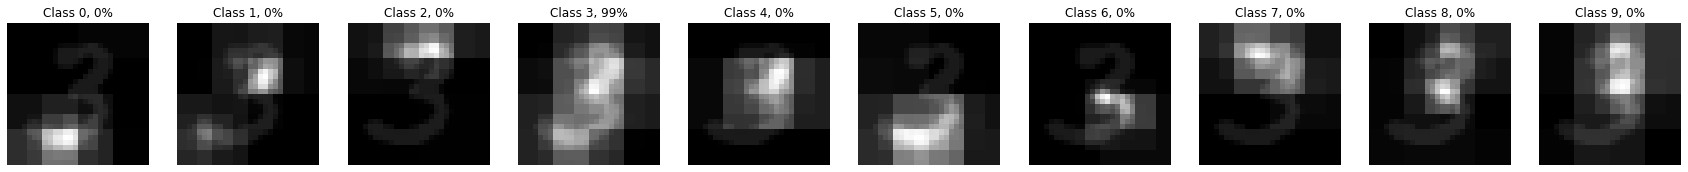

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


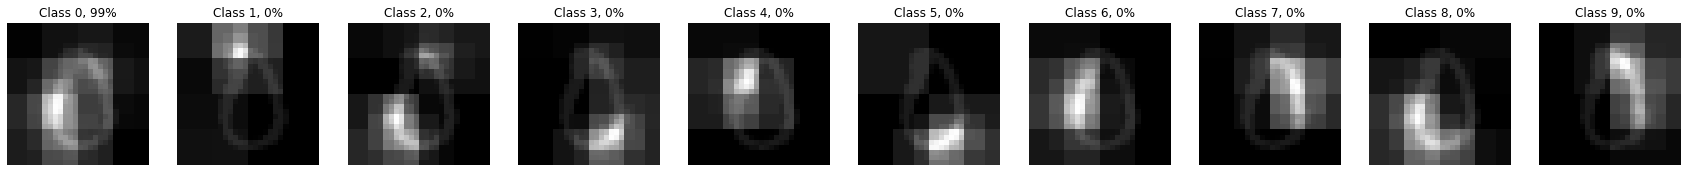

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


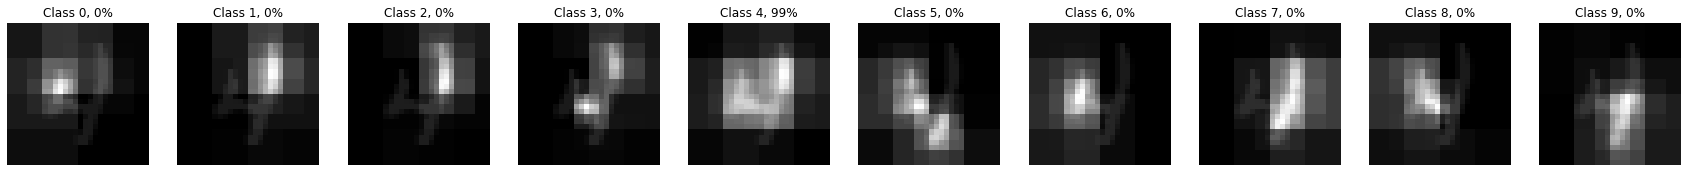

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


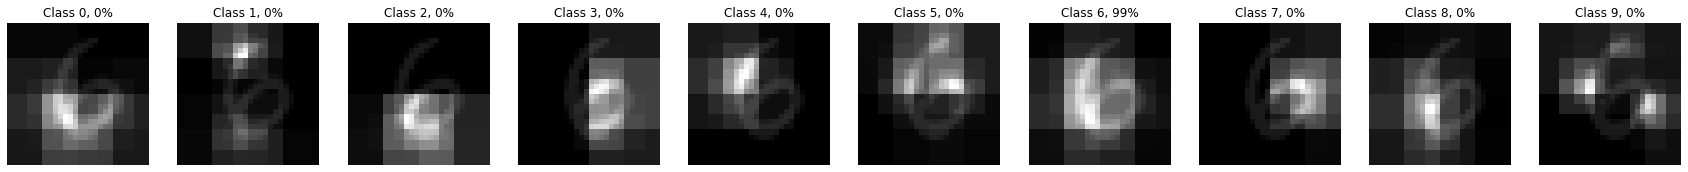

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


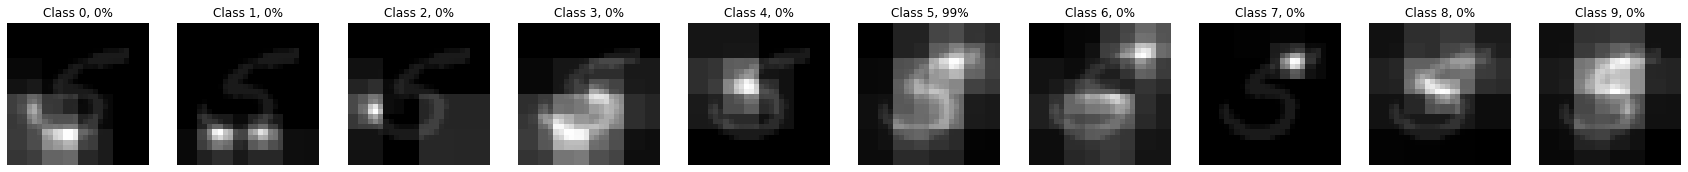

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


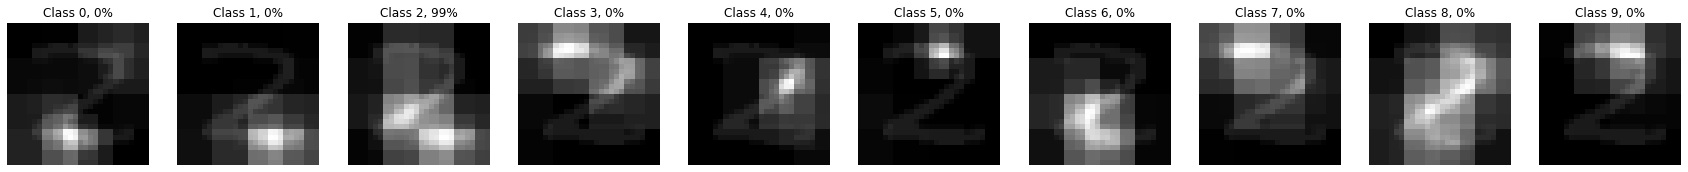

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


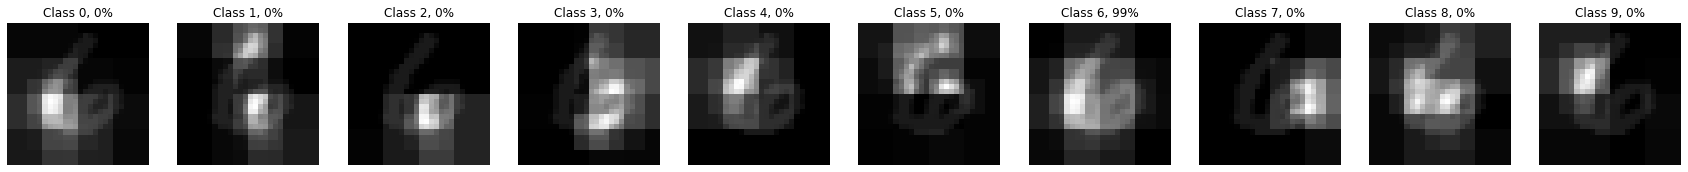

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


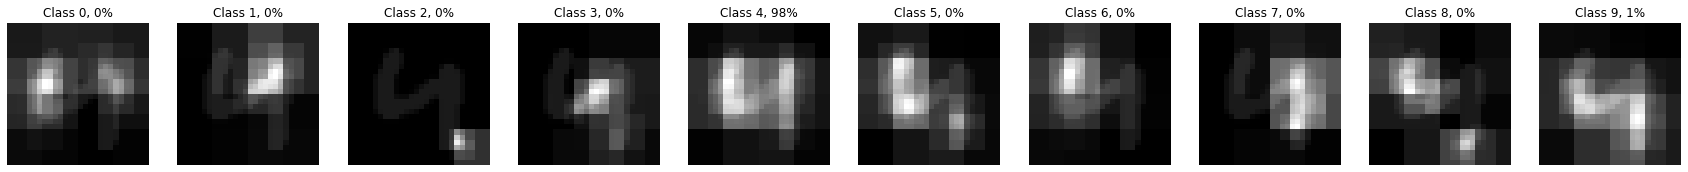

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


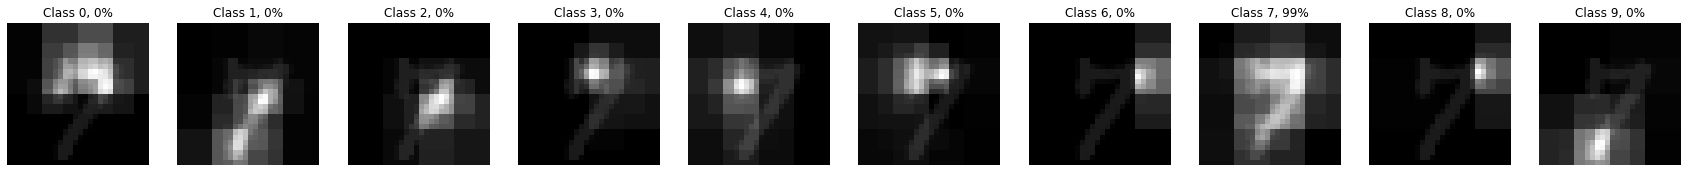

{'perturbation_type': 'fade', 'depth_bound': 0, 'threshold_mode': 'mid-range', 'verbose': False}


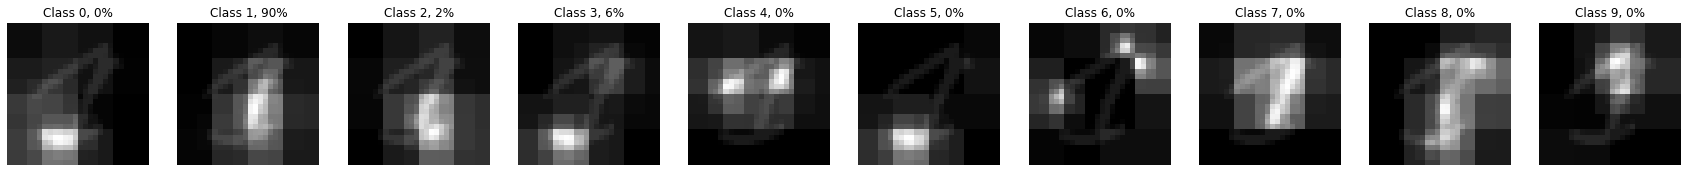

In [17]:

p_list=[
        {'perturbation_type':'fade', 'depth_bound':0, 'threshold_mode':'mid-range', 'verbose':False}
       ]


num_runs = len(p_list)
num_examples = 100

for n in range(num_examples):
    ti, tl = dataiter.next()
    for p in p_list:
        print(p)
        run_hipe(ti, tl, dataiter, p)


